# Imports

We will use some Huggingface libraries for downloading and processing the dataset, and therefore need to install them first.\
The first is the datasets library which allows you to download and manipulate datasets.\
See [their guide](https://huggingface.co/docs/datasets/installation) for an introduction to the datasets library if you want to know more.\
The other library helps us in downloading data from the Huggingface Hub.

We can simple install them using pip:
> Note that `%pip` is a magic command for use in Jupyter Notebooks as discussed in the tutorial on setting up Python!

In [2]:
%pip install datasets huggingface_hub ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [17]:
import zipfile
from functools import partial

import matplotlib.pyplot as plt
import torch
from datasets import load_dataset
from huggingface_hub import hf_hub_download
from torch.utils.data import DataLoader
from tqdm import trange

# Sentiment Analysis

Sentiment Analysis (SA) determines the emotional tone of a text sequence (e.g., a sentence) and classifies it into predefined categories.\
Therefore, **SA is a text classification task which assigns a single class to the whole input**.

In this part, we will use the SST2 dataset, which stands for Stanford Sentiment Treebank.\
This is a binary task where inputs are labeled as `positive` (`1`) or `negative` (`0`).

There are several possibilites on how to 'solve' this task.\
Starting from sequences, there exist many ways to turn them into features.\
A common way is to split them into smaller units, called tokens, which could be words.\
For this, there are again many possibilities how this can be implemented.\
You can do it manually or use some library for it, and there are many NLP libraries.\
Also, the neural network architecture can be almost arbitrary.

## Dataset Loading

There are several possibiliites for downloading datasets.\
You can read them from files, or directly use a library with an online repository of datasets, such as [Huggingface Datasets](https://huggingface.co/docs/datasets/index).

> A note on the Huggingface Datasets library: You can decide where downloaded files are cached, see https://huggingface.co/docs/datasets/v3.2.0/en/cache#cache-directory.\
> The documentation is as always a good source of information!

We will use this library in our example:

In [18]:
# 这行代码是使用Hugging Face的datasets库来加载Stanford Sentiment Treebank v2 (SST-2)数据集。
# load_dataset() 是Hugging Face datasets库中的一个函数，用于加载预定义的数据集
# SST-2是一个用于情感分析的数据集，包含电影评论片段及其对应的情感标签（正面或负面）。这个数据集通常用于训练和评估情感分类模型。
sst2 = load_dataset("stanfordnlp/sst2")
# Print the dataset object to see the dataset's structure
# features指的是数据集中每个样本包含的特征或属性
print(sst2)

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})


If you want to learn more about using this library, there is a very useful [tutorial](https://huggingface.co/docs/datasets/v3.2.0/en/tutorial) available online.

We see that there are three splits, and how many samples are contained in each split.\
Let's take a look at an example.

In [19]:
dataset_train = sst2["train"]
# Print the first sample in the training dataset
print(dataset_train[0])

{'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0}


As we can see, each sample includes an index, the input sentence and a label.\
This sample was labeled `negative` (`0`; `1` stand for `positive` in this dataset).

## Embeddings

In order to turn words into features, we can use pre-trained embeddings.\
These have been trained to carry the semantics of the words.\
See https://nlp.stanford.edu/projects/glove/ for more information.

GloVe embeddings exist trained on different data (varying in the number of tokens and vocabulary size), and with different embedding dimension:

In [20]:
# Download the GloVe embeddings
glove = hf_hub_download("stanfordnlp/glove", "glove.6B.zip")

with zipfile.ZipFile(glove, "r") as f:
    print(f.namelist())

['glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt', 'glove.6B.50d.txt']


In this tutorial, we use the smallest vocabulary size with 300-dimensional features (but feel free to experiment with other dimensions!).\
How does the file look like?

In [21]:
# There are multiple files with different dimensionality of the features in the zip archive: 50d, 100d, 200d, 300d
# 这段代码的主要目的是查看GloVe词向量文件的前几行内容，以了解文件的格式和数据结构。
# 通常，GloVe文件的每一行包含一个词及其对应的向量表示。
# "6B"表示这是基于60亿个词训练的，"300d"表示每个词向量的维度是300。
filename = "glove.6B.300d.txt"
# 这行打开了一个ZIP文件。glove应该是一个包含GloVe词向量文件的ZIP文件路径。
with zipfile.ZipFile(glove, "r") as f:
    # 这个循环遍历ZIP文件中指定文件的每一行。enumerate()函数用于同时获取行索引和行内容。
    for idx, line in enumerate(f.open(filename)):
        print(line)
        # 当读取到第6行（索引为5）时，跳出循环。这意味着代码只会打印文件的前6行。
        if idx == 5:
            break
'''enumerate()允许我们在遍历可迭代对象（如文件行）时，同时获取每个元素的索引和值。
在这个例子中，我们需要知道当前处理的是第几行（索引），以及该行的内容。'''

b'the 0.04656 0.21318 -0.0074364 -0.45854 -0.035639 0.23643 -0.28836 0.21521 -0.13486 -1.6413 -0.26091 0.032434 0.056621 -0.043296 -0.021672 0.22476 -0.075129 -0.067018 -0.14247 0.038825 -0.18951 0.29977 0.39305 0.17887 -0.17343 -0.21178 0.23617 -0.063681 -0.42318 -0.11661 0.093754 0.17296 -0.33073 0.49112 -0.68995 -0.092462 0.24742 -0.17991 0.097908 0.083118 0.15299 -0.27276 -0.038934 0.54453 0.53737 0.29105 -0.0073514 0.04788 -0.4076 -0.026759 0.17919 0.010977 -0.10963 -0.26395 0.07399 0.26236 -0.1508 0.34623 0.25758 0.11971 -0.037135 -0.071593 0.43898 -0.040764 0.016425 -0.4464 0.17197 0.046246 0.058639 0.041499 0.53948 0.52495 0.11361 -0.048315 -0.36385 0.18704 0.092761 -0.11129 -0.42085 0.13992 -0.39338 -0.067945 0.12188 0.16707 0.075169 -0.015529 -0.19499 0.19638 0.053194 0.2517 -0.34845 -0.10638 -0.34692 -0.19024 -0.2004 0.12154 -0.29208 0.023353 -0.11618 -0.35768 0.062304 0.35884 0.02906 0.0073005 0.0049482 -0.15048 -0.12313 0.19337 0.12173 0.44503 0.25147 0.10781 -0.17716 0.03

'enumerate()允许我们在遍历可迭代对象（如文件行）时，同时获取每个元素的索引和值。\n在这个例子中，我们需要知道当前处理的是第几行（索引），以及该行的内容。'

In [22]:
# Unpack the downloaded file
# 这段代码是用来处理GloVe词向量文件并创建词汇表和嵌入矩阵的。
# 创建一个空字典，用于存储单词到索引的映射。
word_to_index = dict()
# 创建一个空列表，用于存储每个单词的嵌入向量。
embeddings = []

with zipfile.ZipFile(glove, "r") as f:
    for idx, line in enumerate(f.open(filename)):
        # 将每行分割成单词和向量值。
        values = line.split()
        # 提取并解码单词（第一个元素）。
        word = values[0].decode("utf-8")
        # 将剩余的值转换为浮点数，然后创建一个PyTorch张量。
        features = torch.tensor([float(value) for value in values[1:]])
        # 将单词和其索引添加到字典中。
        word_to_index[word] = idx
        # 将单词的嵌入向量添加到嵌入列表中。
        embeddings.append(features)
'''这种处理方式非常有用，因为：

1. 它允许我们通过索引快速查找单词的嵌入向量。
2. 它创建了一个可以直接用于深度学习模型的预训练嵌入矩阵。
3. word_to_index字典可以用于将文本数据转换为模型可以处理的数字索引。'''

'这种处理方式非常有用，因为：\n\n1. 它允许我们通过索引快速查找单词的嵌入向量。\n2. 它创建了一个可以直接用于深度学习模型的预训练嵌入矩阵。\n3. word_to_index字典可以用于将文本数据转换为模型可以处理的数字索引。'

### Task
Play around and inspect the dataset!

In [23]:
print(f"Number of words in the vocabulary: {len(word_to_index)}")
# embeddings[0]: 这是获取列表中的第一个元素，也就是第一个单词的嵌入向量。我们使用第一个向量是因为所有向量的维度应该是相同的。
# .shape: 这是PyTorch张量（tensor）的一个属性，返回张量的形状。
# 对于一维张量（向量），shape是一个只包含一个元素的元组，这个元素就是向量的长度。
print(f"Embedding dimensionality: {embeddings[0].shape[0]}")

# Create a reverse mapping from index to word to easily retrieve words from their indices (the line numbers in the file)
# .items() 方法返回一个可以遍历的视图对象，包含字典中的所有键值对。
index_to_word = {idx: word for word, idx in word_to_index.items()}

print(f"First word in the vocabulary: {index_to_word[0]}")
print(f"Last word in the vocabulary: {index_to_word[len(index_to_word) - 1]}")

Number of words in the vocabulary: 400001
Embedding dimensionality: 300
First word in the vocabulary: the
Last word in the vocabulary: <unk>


We bring the embeddings into a useful format:

In [24]:
# Last token in the vocabulary is '<unk>' which is used for out-of-vocabulary words
# We also add a '<pad>' token to the vocabulary for padding sequences
# 它的索引被设置为当前词汇表的长度，也就是说，它会成为词汇表中的最后一个词。
word_to_index["<pad>"] = len(word_to_index)
# 这行代码获取 <pad> 标记的索引，并将其存储在 padding_token_id 变量中。
padding_token_id = word_to_index["<pad>"]
# 这行代码获取 <unk> (unknown) 标记的索引，并将其存储在 unk_token_id 变量中。
unk_token_id = word_to_index["<unk>"]
# 这行代码为 <pad> 标记创建一个全零的嵌入向量，并将其添加到 embeddings 列表中。这个向量的维度与其他嵌入向量相同。
# 这创建了一个新的张量，其形状与第一个嵌入向量相同，但所有元素都被初始化为0。
# 例如，如果原始嵌入是300维的，这将创建一个300维的全零向量。
embeddings.append(torch.zeros(embeddings[0].shape))

# Convert the list of tensors to a single tensor
# torch.stack() 函数将 embeddings 列表中的所有张量堆叠成一个新的张量
'''embeddings（输入）： 这是一个 Python 列表，包含多个 PyTorch 张量。每个张量代表一个词的嵌入向量。
例如，如果我们有 10,000 个词，每个词的嵌入是 300 维的，那么 embeddings 就是一个包含 10,000 个形状为 (300,) 的张量的列表。'''
# 这个操作将所有的嵌入向量堆叠成一个新的二维张量，并将结果赋值回 embeddings 变量。
embeddings = torch.stack(embeddings)
# 是一个 PyTorch 操作，用于获取张量 embeddings 的第二个维度的大小，即每个词嵌入向量的维度；size(0) 会返回词汇表的大小（即词的数量）
# 这个维度信息对于设置后续的神经网络层很重要，特别是在设置嵌入层或者全连接层的输入维度时。
print(f"Embedding shape: {embeddings.size(1)}")

Embedding shape: 300


## Data Processing

Starting from our input sentences, we need to 1) tokenize the sentences to get smaller units (words or tokens) and 2) convert these tokens into vector representations using the pre-trained embeddings.

The datasets library provides support for processing datasets, for more information see https://huggingface.co/docs/datasets/process.


In [25]:
def tokenize(text: str):
    return text.lower().split()


def map_token_to_index(token):
    # Return the index of the token or the index of the '<unk>' token if the token is not in the vocabulary
    # 如果 token 在字典中，返回其对应的索引；如果 token 不在字典中，返回 unk_token_id（未知标记的索引）
    return word_to_index.get(token, unk_token_id)


def map_text_to_indices(text: str):
    return [map_token_to_index(token) for token in tokenize(text)]


def prepare_dataset(dataset):
    # dataset.map(...):对数据集中的每个元素应用一个函数；map 方法通常用于转换数据集中的每个项目
    # lambda 参数: 表达式
    # lambda x: {...}:这是一个匿名函数（lambda函数）它接受一个参数 x，这个 x 代表数据集中的一个项目
    # x 是一个字典，包含了该项目的各种属性
    '''lambda 函数会这样处理它：
        1. 提取 x["sentence"]（"This is a sample sentence."）
        2. 将这个句子传递给 map_text_to_indices 函数
        3. 创建一个新的字典，键为 "token_ids"，值为处理后的结果'''
    # 返回值： lambda 函数返回一个新的字典;这个新字典会替换或添加到原始项目中
    return dataset.map(lambda x: {"token_ids": map_text_to_indices(x["sentence"])})


dataset_train_tokenized = prepare_dataset(dataset_train)

# Print the first sample in the tokenized training dataset
print(dataset_train_tokenized[0])

{'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0, 'token_ids': [5708, 50, 52776, 25, 0, 13054, 1503]}


Next, we need a dataloader that takes care of batching our data.\
You have seen this before, but this time we need also take care of padding, since the length of the sentences varies in our dataset.

In [26]:
# 用于对批次数据进行填充处理，因为所有的句子不是一样长
# keys_to_pad: 需要填充的键列表，默认是 ["token_ids"]。padding_value: 用于填充的值，默认是 -1。
def pad_inputs(batch, keys_to_pad=["token_ids"], padding_value=-1):
    # Pad keys_to_pad to the maximum length in batch
    padded_batch = {}
    '''由于默认情况下 keys_to_pad 只包含 "token_ids"，所以在默认情况下：
    循环只会执行一次
    key 的值将会是字符串 "token_ids"'''
    for key in keys_to_pad:
        # Get maximum length in batch
        # sample是一个字典，包含一个键为 "token_ids" 的项，对应的值是一个列表
        max_len = max([len(sample[key]) for sample in batch])
        # Pad all samples to the maximum length
        # sample[key]: 获取原始数据
        # + [padding_value] * (max_len - len(sample[key])): 在原始数据后添加填充值，使其长度达到 max_len
        padded_batch[key] = torch.tensor(
            [
                sample[key] + [padding_value] * (max_len - len(sample[key]))
                for sample in batch
            ]
        )
    # Add remaining keys to the batch
    # 这行代码遍历批次中第一个样本的所有键。批次是一个列表，每个元素都是一个字典，代表一个样本。
    '''这段代码的主要目的是确保批次中所有不需要填充的数据也被正确地转换为张量并包含在最终的 padded_batch 中。
    这样，返回的批次数据就包含了所有原始数据，其中需要填充的数据已经被填充到相同长度，
    而不需要填充的数据则保持原样，只是被转换成了张量格式。'''
    '''如果键不需要填充，这行代码会执行以下操作：
        1. 使用列表推导式 [sample[key] for sample in batch] 从批次中的每个样本提取该键的值。
        2. 将提取的值列表转换为 PyTorch 张量。
        3. 将这个张量存储在 padded_batch 字典中，使用相同的键。'''
    for key in batch[0].keys():
        if key not in keys_to_pad:
            padded_batch[key] = torch.tensor([sample[key] for sample in batch])
    return padded_batch


# 参数 batch_size：每个批次的样本数，默认为32; 参数 shuffle：是否打乱数据顺序，默认为False。
# 这个函数的主要作用是封装了 DataLoader 的创建过程，并设置了自定义的填充行为。
def get_dataloader(dataset, batch_size=32, shuffle=False):
    # Create a DataLoader for the dataset
    return DataLoader(
        dataset,
        batch_size=batch_size,
        # 用于处理和组合样本列表以形成小批量的函数
        # 使用 partial 函数创建一个新的函数，这个新函数基于 pad_inputs，但预设了 padding_value 参数为 padding_token_id。
        # 这意味着当 DataLoader 调用这个函数来创建批次时，它会使用 pad_inputs 来处理可变长度的序列，并用 padding_token_id 进行填充。
        # partial允许我们基于一个已有的函数创建一个新的函数，同时预设一些参数；这在很多情况下都非常有用，特别是当你需要多次使用同一个函数，但每次只改变其中的一部分参数时。
        # 为什么需要把padding_value设为padding_token_id
        # padding_token_id 通常是词汇表中专门为填充保留的一个特殊标记的ID
        # 这里的padding_token_id是词汇表中的最后一个ID
        collate_fn=partial(pad_inputs, padding_value=padding_token_id),
        shuffle=shuffle,
    )


# We select the columns that we want to keep in the dataset
# 这行代码使用with_format方法选择了dataset_train_tokenized数据集中的"token_ids"和"label"两列。
# 这样可以确保在后续处理中只使用这两列数据。
'''with_format方法是Hugging Face datasets库中的一个功能，用于指定数据集的输出格式。
这个方法允许你选择或重新排列数据集中的列，以及设置其他格式选项。'''
dataset_train_tokenized = dataset_train_tokenized.with_format(
    columns=["token_ids", "label"]
)
# Create a DataLoader for the training dataset
# 这里调用了之前定义的get_dataloader函数，为训练数据集创建一个DataLoader。设置了批次大小为8，并启用了数据打乱（shuffle=True）
dataloader_train = get_dataloader(dataset_train_tokenized, batch_size=8, shuffle=True)

for batch in dataloader_train:
    token_ids = batch["token_ids"]
    labels = batch["label"]
    print(token_ids)
    print(labels)
    break

tensor([[ 66940,   6333,     60,      6,     26,    261,  31221,   5247,      3,
          58369,   9070,      2, 400001, 400001, 400001, 400001, 400001, 400001,
         400001, 400001],
        [    55,  10132,   5348, 400001, 400001, 400001, 400001, 400001, 400001,
         400001, 400001, 400001, 400001, 400001, 400001, 400001, 400001, 400001,
         400001, 400001],
        [    14,  12316,    434, 400001, 400001, 400001, 400001, 400001, 400001,
         400001, 400001, 400001, 400001, 400001, 400001, 400001, 400001, 400001,
         400001, 400001],
        [    81,    107,    998,  12535,      4,   1716,      0,    319,   1495,
             46,   2065,     60,      7,    539,     13,      0,   1698,      2,
         400001, 400001],
        [  8039,  18080,     17,      7,  16674,  31527,    161,      3,   3742,
            268, 400001, 400001, 400001, 400001, 400001, 400001, 400001, 400001,
         400001, 400001],
        [     4,    134,      0, 400000,    978,   1005,    

## Model
We will use a simple network here with the pre-trained embeddings.

In [27]:
# torch.nn.Module是PyTorch中所有神经网络模块的基类
class SimpleTextClassifier(torch.nn.Module):
    # embeddings：预训练的词嵌入矩阵
    # hidden_size：隐藏层的大小
    # padding_index：填充符号的索引
    def __init__(self, embeddings, hidden_size=128, padding_index=-1):
        super().__init__()
        # 这行代码创建了一个预训练的嵌入层
        # torch.nn.Embedding.from_pretrained(): 这是PyTorch中创建预训练嵌入层的方法。
        # 它允许你使用已经训练好的词嵌入来初始化Embedding层。
        # freeze=True: 这个参数设置为True表示在训练过程中，这些嵌入权重将不会被更新。这通常用于保持预训练嵌入的原始信息，特别是当你认为这些预训练嵌入已经足够好，或者你的训练数据较少时
        # padding_idx=padding_index: 这个参数指定了用于填充的索引。在自然语言处理中，我们经常需要将不同长度的序列填充到相同长度。
        self.embedding = torch.nn.Embedding.from_pretrained(
            embeddings, freeze=True, padding_idx=padding_index
        )
        # 这行代码创建了一个隐藏层
        # shape[0] 表示第一个维度，通常是批次大小（batch size）或行数。
        # shape[1] 表示第二个维度，在二维张量中，这通常是列数。
        # 对于词嵌入矩阵：
        #     embeddings.shape[0] 通常表示词汇表的大小（即有多少个不同的词）。
        #     embeddings.shape[1] 表示每个词嵌入向量的维度。
        self.layer1 = torch.nn.Linear(embeddings.shape[1], hidden_size)
        # 这行代码创建了一个输出层
        self.output_layer = torch.nn.Linear(hidden_size, 2)

    def forward(self, x):
        # 将输入转换为词嵌入向量
        x = self.embedding(x)
        # By summing the embeddings of all tokens in the sequence, we get a bag-of-words vector for each sample input
        # 对序列中所有词的嵌入进行求和，得到句子表示
        '''
  [[1,1,1,1], [2,2,2,2], [3,3,3,3]],  # 第一个句子
  [[4,4,4,4], [5,5,5,5], [6,6,6,6]]   # 第二个句子
  求和后的结果将是：
  [6,6,6,6],   # 第一个句子的表示 (1+2+3, 1+2+3, 1+2+3, 1+2+3)
  [15,15,15,15] # 第二个句子的表示 (4+5+6, 4+5+6, 4+5+6, 4+5+6)
'''
        x = torch.sum(x, dim=1)
        x = torch.relu(self.layer1(x))
        x = self.output_layer(x)
        return x

We instantiate and verify that the model is working (no errors):

In [28]:
# 这段代码创建了一个 SimpleTextClassifier 模型实例，并使用它对训练数据集的前两个样本进行预测
model = SimpleTextClassifier(embeddings, padding_index=padding_token_id)
# 从 dataset_train_tokenized 中获取 "token_ids" 列的前两个样本
# 将这些样本转换为 PyTorch 张量
# 将准备好的输入张量传入模型;这会触发模型的 forward 方法，执行前向传播
print(model(torch.tensor(dataset_train_tokenized["token_ids"][:2])))

tensor([[ 0.4960,  0.3375],
        [-0.0364,  0.2072]], grad_fn=<AddmmBackward0>)


### Task
How would you use an RNN instead of this simple feed-forward network?\
See https://pytorch.org/docs/stable/nn.html#recurrent-layers for details on how to use RNNs in PyTorch.

![RNN for Sentence Classification](https://www.tensorflow.org/static/text/tutorials/images/bidirectional.png)\
Source: https://www.tensorflow.org/text/tutorials/text_classification_rnn

In [31]:
class RNNTextClassifier(torch.nn.Module):
    # num_layers: RNN的层数，默认为1
    # bidirectional: 是否使用双向RNN，默认为True
    def __init__(
        self,
        embeddings,
        hidden_size=128,
        padding_index=-1,
        num_layers=1,
        bidirectional=True,
    ):
        # 调用父类 torch.nn.Module 的初始化方法
        super().__init__()
        # 创建一个嵌入层，使用预训练的嵌入矩阵初始化。freeze=True 表示在训练过程中不更新这些嵌入
        self.embedding = torch.nn.Embedding.from_pretrained(
            embeddings, freeze=True, padding_idx=padding_index
        )
        # 创建RNN层。输入大小是嵌入维度embeddings.shape[1]，隐藏状态大小是 hidden_size。
        # batch_first=True 表示输入的第一个维度是批次大小。
        # num_layers=1 设置RNN的层数,默认为1
        self.rnn = torch.nn.RNN(
            embeddings.shape[1],
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
        )
        # torch.nn.Linear: 这是PyTorch中的线性层类。它实现了 y = xA^T + b 的操作,其中 A 是权重矩阵,b 是偏置向量
        # num_layers: RNN的层数；int(bidirectional) + 1: 如果是双向RNN则为2,否则为1；idden_size: 每个RNN单元的隐藏状态大小
        # 输出特征数: 2 这表示输出层将产生两个值，分别代表正面和负面情感。
        '''将这三个值相乘的原因：
            对于每一层（num_layers），我们都有一个隐藏状态。
            对于每个方向（单向或双向，由 int(bidirectional) + 1 决定），我们都有一个隐藏状态。
            每个隐藏状态的大小都是 hidden_size。
           这个计算确保我们考虑了RNN所有层和所有方向的输出，从而正确地设置了线性层的输入大小'''
        self.output_layer = torch.nn.Linear(
            num_layers * (int(bidirectional) + 1) * hidden_size, 2
        )

    def forward(self, x):
        x = self.embedding(x)
        # RNN模型返回两个值，被解包到 all_hidden_states 和 last_hidden_state
        # all_hidden_states: 通常是一个张量，包含了所有时间步的隐藏状态
        # last_hidden_state: 最后一个时间步的隐藏状态。对于单向RNN，这就是最后的输出；对于双向RNN，这可能包含前向和后向的最后状态。
        all_hidden_states, last_hidden_state = self.rnn(x)
        # Concatenate the hidden states of all layers and directions
        # 这通常意味着 last_hidden_state 可能是一个元组或其他可迭代对象，包含多个张量
        # torch.cat(...)PyTorch的concatenate函数，用于沿指定维度连接张量
        # dim=-1 指定沿最后一个维度进行连接；在PyTorch中，-1 表示最后一个维度
        '''这个操作的含义和用途：
            在双向RNN中，last_hidden_state 可能包含前向和后向的最后隐藏状态。
            在多层RNN中，它可能包含每一层的最后隐藏状态。
            通过连接这些状态，我们得到一个更大的、包含所有信息的表示。'''
        hidden_state = torch.cat(list(last_hidden_state), dim=-1)
        # hidden_state = torch.cat([tensor for tensor in last_hidden_state], dim=-1)
        output = self.output_layer(hidden_state)
        return output

In [33]:
model = RNNTextClassifier(embeddings, padding_index=padding_token_id)
print(model(torch.tensor(dataset_train_tokenized["token_ids"][0])))

tensor([ 0.4096, -0.1635], grad_fn=<ViewBackward0>)


## Evaluation

To assess the performance of our model, we compute a metric that fits for our task.\
For pure classification like SA, this is often the accuracy and optionally also the loss on the provided dataset:

In [35]:
def compute_accuracy(predictions: torch.tensor, labels: torch.tensor):
    # torch.argmax(predictions, dim=1) == labels: This compares the predicted classes with the true labels, creating a boolean tensor.
    # torch.sum(...): This sums up the boolean tensor, effectively counting the number of correct predictions.
    # .item(): This extracts the single value from the resulting tensor.
    # / len(labels): This divides the count of correct predictions by the total number of samples, giving the accuracy as a fraction.
    return torch.sum(torch.argmax(predictions, dim=1) == labels).item() / len(labels)

# model: 要评估的模型；dataset: 用于评估的数据集；loss_fn: 可选的损失函数
def evaluate_model(model, dataset, loss_fn=None):
    # Compute the accuracy and optionally the loss of the model on the dataset
    # 数据准备：使用get_dataloader函数创建一个批量大小为32的数据加载器
    dataloader = get_dataloader(dataset, batch_size=32)
    # 存储每个批次的准确率和损失
    accuracies = []
    losses = []
    # We don't need to compute gradients for the evaluation
    # torch.no_grad() 是 PyTorch 中的一个上下文管理器，用于临时禁用梯度计算；离开上下文时，会恢复之前的梯度计算状态。
    with torch.no_grad():
        for batch in dataloader:
            # 获取输入(token_ids)和标签(labels)；使用模型进行预测
            # 如果提供了损失函数，计算损失并存储
            token_ids = batch["token_ids"]
            labels = batch["label"]
            predictions = model(token_ids)
            if loss_fn:
                loss = loss_fn(predictions, labels)
                losses.append(loss.item())
            accuracies.append(compute_accuracy(predictions, labels))
    return sum(accuracies) / len(accuracies), (
        (sum(losses) / len(losses)) if loss_fn else None
    )
'''这个函数的主要目的是在不进行梯度计算的情况下，评估模型在整个数据集上的性能。
它返回模型的平均准确率，以及可选的平均损失值。'''

Since we want to evaluate our model on a separate dataset, we will also have to process this similarly to our training data:

In [36]:
dataset_val = sst2["validation"]
dataset_val_tokenized = prepare_dataset(dataset_val)
dataset_val_tokenized = dataset_val_tokenized.with_format(
    columns=["token_ids", "label"]
)

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Now we can evaluate our model:

In [37]:
accuracy, _ = evaluate_model(model, dataset_val_tokenized)
print(f"Accuracy on the validation dataset: {accuracy}")

Accuracy on the validation dataset: 0.49888392857142855


With randomly initialized weights, we expect to end up at ~50% Accuracy (in average)!

## Training

Now having processed the data and instantiated our model, it is time for training.\
Therefore, we need a loss function and an optimizer.\
The rest is just a simple training loop as before.

In [38]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [39]:
losses_train, losses_val = [], []
accuracies_train, accuracies_val = [], []

# Compute loss and accuracy on the training set
accuracy, loss = evaluate_model(model, dataset_train_tokenized, loss_fn)
losses_train.append(loss)
accuracies_train.append(accuracy)

# Compute loss and accuracy on the validation set
accuracy, loss = evaluate_model(model, dataset_val_tokenized, loss_fn)
losses_val.append(loss)
accuracies_val.append(accuracy)

NUM_EPOCHS = 10

# A progress bar to visualize the training progress
pbar = trange(NUM_EPOCHS)
# Training loop
for epoch in pbar:
    # Do one epoch of training
    for batch in dataloader_train:
        # Extract the token ids and the labels from the batch
        token_ids = batch["token_ids"]
        labels = batch["label"]

        # Forward pass
        predictions = model(token_ids)
        loss = loss_fn(predictions, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate the loss and accuracy on the training set
    acc_train, loss_train = evaluate_model(model, dataset_train_tokenized, loss_fn)
    accuracies_train.append(acc_train)
    losses_train.append(loss_train)

    # Evaluate the model on the validation set
    acc_val, loss_val = evaluate_model(model, dataset_val_tokenized, loss_fn)
    accuracies_val.append(acc_val)
    losses_val.append(loss_val)
    # 这行代码是用来更新进度条（progress bar）的后缀信息的
    # set_postfix_str() 是一个方法，用于设置进度条的后缀字符串
    pbar.set_postfix_str(
        f"Train loss: {losses_train[-1]} - Validation acc: {accuracies_val[-1]}"
    )

100%|██████████| 10/10 [26:25<00:00, 158.57s/it, Train loss: 0.27026688505026053 - Validation acc: 0.8024553571428571]


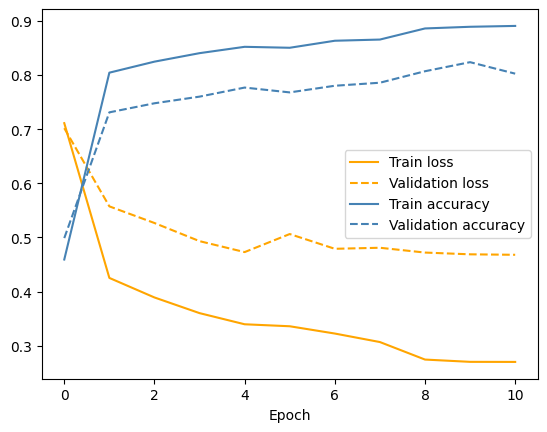

In [40]:
# Visualize the loss and accuracy
plt.plot(losses_train, color="orange", linestyle="-", label="Train loss")
plt.plot(losses_val, color="orange", linestyle="--", label="Validation loss")
plt.plot(accuracies_train, color="steelblue", linestyle="-", label="Train accuracy")
plt.plot(accuracies_val, color="steelblue", linestyle="--", label="Validation accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## Interactive Inference

We'd like to perform some interactive testing with our trained model.\
Widgets allow for a simple text interface:

In [43]:
from ipywidgets import widgets
from IPython.display import display

sentence_widget = widgets.Text(
    value="This movie is terrible",
    placeholder="Type something",
    description="Sentence:",
    disabled=False,
)
display(sentence_widget)

Text(value='This movie is terrible', description='Sentence:', placeholder='Type something')

### Task

Now the task is to do a prediction for the provided sentence using our trained model.

Some hints:
* You need to convert the input sentence to token ids, using the same mapping as for training. Can you re-use something to accomplish this?
* Since we only have a single input, we don't need batching nor a dataloader
* We don't need the gradients from the model

In [44]:
sentence = sentence_widget.value
# 使用 map_text_to_indices 函数将句子转换为词元（token）索引。
# 将结果包装成 PyTorch 张量
token_ids = torch.tensor([map_text_to_indices(sentence)])
with torch.no_grad():
    # 将词元索引输入模型，获取预测结果
    predictions = model(token_ids)
# torch.argmax() 找出预测张量中最大值的索引
# .item() 将结果转换为 Python 标量
predicted_class = torch.argmax(predictions).item()
print(f"The predicted class for the sentence '{sentence}' is: {'positive' if predicted_class == 1 else 'negative'}")

The predicted class for the sentence 'This movie is great' is: positive
